# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone Project

In this project, which is part of the Capstone project of the [IBM Data Science Professional Certificate](https://www.coursera.org/professional-certificates/ibm-data-science) the aim is to define an interesting business problem which would need to leverage the Foursquare location data to solve. 

## Table of contents
* [What you need to run this notebook](#dependencies)
* [Introduction](#introduction)
    * [Business Problem](#businessProblem)
* [Data collection](#data)
    * [Search area](#search_area)
    * [Restaurant list extraction](#get_restaurant_list)
* [Analysis](#analysis)
    * [Data preprocessing](#preproc)
    * [Heatmaps](#heatmaps)
    * [Important Factors](#important_factors)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## What you need to run this notebook <a name="dependencies"></a>

* Foursquare developer credentials ([here](https://developer.foursquare.com/)).
* [folium](https://python-visualization.github.io/folium/) - for creating interactive maps.
* [geopy](https://geopy.readthedocs.io/en/stable/) - for converting coordinates into addresses and vice versa.
* [python-dotenv](https://pypi.org/project/python-dotenv/) - to read .env files.
* [pandas](https://www.scipy.org/install.html#pip-install) - for data manipulation.
* [numpy](https://www.scipy.org/install.html#pip-install) - for data manipulation and scientific computing.
* [pyproj](https://pyproj4.github.io/pyproj/stable/) - for transforming latitude and longitude to UTM coordinates and vice versa (used in utils.py).
* [requests](https://pypi.org/project/requests/) - for making server requests (used in fsquare.py).
* [matplotlib](https://matplotlib.org/) - for creating useful plots
* [sklearn](https://scikit-learn.org/stable/index.html) - for using some well known machine learning techniques

## Introduction <a name="introduction"></a>

### Project aim: Find the best location in Berlin to open a Vietnamese restaurant 

### Business Problem <a name="businessProblem"></a>

**Background:** Suppose you are the owner of a successfull Vietnamese restaurant chain in the UK that wants to open their first restaurant in Berlin, Germany. You ask yourself: _"Where should I even open my first restaurant?"_. In an ever increasing data-driven world you realize that you could leverage the hard-won skills of a Data Scientist to help you uncover business value from relevant data which would allow you to reach to a decision. You find a Data Scientist and give him/her this description: _"I want to open a restaurant in Berlin that would serve Vietnamese food. Which is the best location and why? Show me facts that would support your analysis and conclusion."_


What follows is the analysis that was conducted by the Data Scientist.


## Data collection <a name="data"></a>

For this project the Foursquare api for restaurant location data will be used. The code used to extract the data will be described in this section along with some useful results and plots obtained from processing the api responses.

In [1]:
import sys
sys.path.append("../")

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent `'foursquare_agent'`, as shown below.

In [2]:
#!pip install geopy  # if geopy is not already installed
from geopy.geocoders import Nominatim  # to convert an address into latitude and longitude values


def address_coordinates(address:str) -> list:
    """Return the location points given an address.
    
    Uses the Nominatim geocoder from OpenStreetMap.
    """
    try:
        # define a custom user_agent and get the location
        location = Nominatim(user_agent="foursquare_agent").geocode(address)
        # decode the location data
        lat = location.latitude
        lon = location.longitude
        return [lat, lon]
    except:
        return [None, None]
    
    
def reverse_address_coordinates(coords:list) -> str:
    """Return the address given the location points.
    
    Uses the Nominatim geocoder from OpenStreetMap.
    """
    try:
        # define a custom user_agent and get the address
        return Nominatim(user_agent="foursquare_agent").reverse(coords)
    except:
        raise
        return None


ADDRESS = 'Alexanderplatz, Berlin, Germany'  # approximately at the centre of Berlin
BERLIN_CENTRE = address_coordinates(ADDRESS)
print(f'Coordinates of {ADDRESS} are [{BERLIN_CENTRE[0]:.2f}, {BERLIN_CENTRE[1]:.2f}]\n')
print(reverse_address_coordinates(BERLIN_CENTRE))


Coordinates of Alexanderplatz, Berlin, Germany are [52.52, 13.41]

U Alexanderplatz, Alexanderplatz, Mitte, Berlin, 10178, Deutschland


### Search area <a name="search_area"></a>

The search area is defined by creating a grid centred at `BERLIN_CENTRE`. Convert location data to cartesian coordinates for easier data calculations. The squared grid with dimension `SIDE_LENGTH` consists of circular areas of radius equal to `MINOR_RADIUS`. The aim is to get a list of all restaurants per grid area.

In [3]:
# !pip install numpy
import numpy as np
from utility.utils import lonlat_to_xy, create_grid

print(f'numpy version: {np.__version__}')


# sanity check
x, y = lonlat_to_xy(Lon=BERLIN_CENTRE[1], Lat=BERLIN_CENTRE[0])
lo, la = lonlat_to_xy(x, y, inverse=True)
assert(round(BERLIN_CENTRE[0], 4)==round(la, 4))
assert(round(BERLIN_CENTRE[1], 4)==round(lo, 4))

# convert BERLIN_CENTRE to UTM coordinates
berlin_centre_xy = lonlat_to_xy(Lon=BERLIN_CENTRE[1], Lat=BERLIN_CENTRE[0])

# parameters
SIDE_LENGTH = 6000  # search length in meters with middle point at berlin_centre_xy
MINOR_RADIUS = 500  # grid shapes' radius in meters
# Note: The values above should take into account the number of API calls
# a developer can make. Check out https://developer.foursquare.com/docs/api/troubleshooting/rate-limits

# create the grid
grid_centres_x, grid_centres_y, area_radius = create_grid(centre=berlin_centre_xy,
                                                          length=SIDE_LENGTH,
                                                          minor_radius=MINOR_RADIUS,
                                                          area_shape='circle',
                                                          ov=True)
# store into a single numpy array for easier manipulation
grid_centres_xy = np.concatenate((grid_centres_x.T.reshape(np.prod(grid_centres_x.shape), 1),
                                  grid_centres_y.reshape(np.prod(grid_centres_y.shape), 1)),
                                 axis=1)

# convert cartesian grid centres to longitude and latitude
grid_centres_lo, grid_centres_la = lonlat_to_xy(grid_centres_x, grid_centres_y, inverse=True)

# store into a single numpy array for easier manipulation
grid_centres_longla = np.concatenate((grid_centres_lo.T.reshape(np.prod(grid_centres_lo.shape), 1),
                                      grid_centres_la.reshape(np.prod(grid_centres_la.shape), 1)),
                                     axis=1)

print(f'=====> Number of Foursquare API calls to make={grid_centres_longla.shape[0]}.')

# sanity check
assert(np.unique(np.sum(grid_centres_longla, axis=1)).shape[0]==grid_centres_longla.shape[0])

numpy version: 1.18.1
=====> Number of Foursquare API calls to make=400.


Let's visualise the grid search area where the `BERLIN_CENTRE` coordinates are clearly indicated in the middle of the map. The blue circle markers on the other hand indicate the centre of each minor grid area.

In [4]:
#!pip install folium
import folium

In [5]:

map_berlin = folium.Map(location=BERLIN_CENTRE, zoom_start=12)
folium.Marker(BERLIN_CENTRE, popup=ADDRESS.split(',')[0]).add_to(map_berlin)
for longlat in grid_centres_longla:
    lon = longlat[0]
    lat = longlat[1]
    folium.Circle([lat, lon], radius=2, color='blue', fill=True, fill_opacity=1).add_to(map_berlin)

map_berlin  # show the map

### Restaurant list extraction  <a name="get_restaurant_list"></a>

The next step is to communicate with the Foursquare API and fetch information about relevant venues in each of the minor grid areas. You need to have Foursquare credentials for this. Once you obtain them either paste them in the else statement below or create your own .env file and paste them in there (recommended) using `CLIENT_ID` and `CLIENT_SECRET` as the variable names.

In [6]:
# !pip install python-dotenv
from dotenv import load_dotenv  # to read .env
from pathlib import Path
import os


# load the Foursquare credentials from .env (hidden file)
if load_dotenv(dotenv_path=Path('..') / '.env'):
    CLIENT_ID = os.getenv("CLIENT_ID")
    CLIENT_SECRET = os.getenv("CLIENT_SECRET")
    print('Credentials loaded from file')
else:
    CLIENT_ID = "Your Foursquare Client ID"
    CLIENT_SECRET = "Your Foursquare Client Secret"


Credentials loaded from file


To obtain the list of restaurants we can either use a search endpoint (see [Foursquare documentation](https://developer.foursquare.com/docs)) with a relevant search string or seek for specific venue category identities. The former might not be a suitable choice in this case as you probably need more than just 1 or 2 words to get all the food venues (restaurants, Biergartens, imbiss, Bistro Cafes etc.) that also serve more than light meals and are likely competitors to your business. Therefore, searching by category identity is more practical and guarantees that all relevant venues will be obtained.

Firstly, all food venues will be fetched using the Food category id found from the documentation [here](https://developer.foursquare.com/docs/resources/categories).
<br><br>
**Note:** To communicate with the Foursquare API I created the fsquare class module for easier usage, maintenance and code distribution (feel free to use it in your own projects).

In [7]:
import json
import fsquare  # my module for making api calls and fetching relevant data


##===== Parameters =====##
# Categories:  (source: https://developer.foursquare.com/docs/resources/categories)
SEARCH_CATEGORY = ('4d4b7105d754a06374d81259',)  # Food search category. Made immutable to avoid accidentally changing it
load_results_from_file = True  # Set to False to make api calls

# create the foursquare class instance
fsq = fsquare.fsquare(CLIENT_ID, CLIENT_SECRET)

##===== Search parameters =====##
fixed_search_params, search_params = fsq.fsquare_search_settings(BERLIN_CENTRE[0], BERLIN_CENTRE[1])
search_params['radius'] = MINOR_RADIUS  # minor grid area radius
api_params = {'search_params': search_params, 'fixed_search_params': fixed_search_params}
# queries = ['restaurant']#['Vietnamesische', 'Vietnamese']
queries = [SEARCH_CATEGORY[0]]

##===== Get the data =====##
if load_results_from_file:
    with open('../data/foursquare_data.json') as json_file:
        fsqdata = json.load(json_file)
else:
    fsqdata = fsq.get_fsquare_data(api_params,
                                   queries,
                                   tp='cat',  # perform a category search
                                   coords=grid_centres_longla,
                                   verbose=1)
    if fsqdata:
        print('Obtained Foursquare data successfully')
    else:
        raise ValueError('Something went wrong!')

    # Check for duplicates
    assert(len(fsqdata['venue_ids'])==len(set(fsqdata['venue_ids'])))
    
    # save the data
    with open('../data/foursquare_data.json', 'w') as json_file:
        json.dump(fsqdata, json_file)
    print('Data saved successfully!')

In [8]:
fsqdata.keys()

dict_keys(['venues', 'venue_ids'])

Now we should search for only the relevant venue categories. This requires the specific category identities which can be achieved by making an API call or by manually adding the relevant identities by looking at the documentation [here](https://developer.foursquare.com/docs/resources/categories). There are a lot of categories in our case so the first option is more practical. An additional benefit of this approach is that you don't need to continuously check for any changes in the documentation and then manually updating your list of category identities as you can programmatically take care of that. 

To eliminate unrelated venue categories an easy solution is to specify a string that needs to be present in the category name (`word_to_include`). In this case, we are only interested in the restaurant type of categories so `word_to_include` is set to 'restaurant'.

In [9]:
# consider venue categories with the following string in their name
word_to_include = 'restaurant'  # case insensitive

# Get all the venue categories (from the Foursquare API docs)
all_categories, categories_to_include = fsq.get_all_fsquare_categories(api_params["fixed_search_params"],
                                                                       categ_name='Food',  # main category name
                                                                       w=word_to_include)
# sanity check
assert(len(categories_to_include)==len(set(categories_to_include)))  # check for duplicates
print('Ignode status code 200')

Ignode status code 200


../fsquare.py:268: UserWarning: API response status code: 200
  warn(f"API response status code: {code}")


Now we need to find all the restaurants within each area. Separate Vietnamese and other Asian restaurants from the rest. Will be used for plotting later.

In [10]:
from typing import List, Tuple


def get_restaurants(tp: List[str], categs: dict, include: List[str]) -> Tuple:
    """Returns the restaurants to be used for further analysis.
    
    Arguments:
    ----------
    tp: List[str],
        The venue types for restaurant categorization.
    
    categs: dict,
        The venue categories for each venue type in tp.
    
    include: List[str],
        The foursquare category identities to include in
        the returned restaurants dictionary, additional to
        the ones in categs.
    
    Returns:
    --------
    restaurants: dict,
        The restaurants to be used for further analysis.
    
    not_added: List[str],
        The names of the restaurants not added in the
        restaurants dictionary.
    """
    # to store the API reponses of the venues of interest
    restaurants = {item:[] for item in tp}

    # append with venue names that are not added to the restaurants dictionary
    not_added = []
    
    # populate with the correct category id
    for venue in fsqdata['venues']:
        v_id = venue['categories'][0]['id']
        if v_id in categs:
            restaurants[categs[v_id]].append(venue)
        elif v_id in categories_to_include:
            restaurants[tp[0]].append(venue)  # append to the 'Other restaurants'
        else:
            # don't add any venues that are not direct competitors (e.g. bakeries, cafes)
            not_added.append(venue['name'])
    print(f"{len(not_added)} venues not added.")
    return restaurants, not_added


##===== Parameters =====##
# Venue category names of interest
venue_types = ['Other restaurants', 'Other Asian', 'Vietnamese']

# Categories:  (source: https://developer.foursquare.com/docs/resources/categories)
venue_categories = {'4d4b7105d754a06374d81259': venue_types[0],  # Food
                    '4bf58dd8d48988d142941735': venue_types[1],  # Asian Restaurant
                    '4bf58dd8d48988d14a941735': venue_types[2]}  # Vietnamese Restaurant

##===== Get the list of restaurants =====##
restaurants, not_added = get_restaurants(tp=venue_types, categs=venue_categories, include=categories_to_include)

# sanity check: check the venues that don't have word_to_include in their category name
# These should only come from the primary category 'Food' (i.e. the SEARCH_CATEGORY)
print(f"Check the venue that don't have the word '{word_to_include}' in their name:")
catIDs = list()
for item in restaurants['Other restaurants']:
    name = item['categories'][0]['name']
    if word_to_include.lower() not in name.lower():
        print(f'\tCategory name: {name}. Venue name: {item["name"]}')
        catIDs.append(item['categories'][0]['id'])
assert(len(set(catIDs))==1)  # ensure that it's only 1 unique category
assert(catIDs[0]==SEARCH_CATEGORY[0])  # and it is the SEARCH_CATEGORY
print('No problems found!\n')

##===== details =====##
# an example of a venue that is not considered as a competitor
print(f"Example of venue not added: '{not_added[-1]}'\n")

print('Number of restaurants per category:')
total_venues = 0
for i,c in enumerate(venue_types):
    total_venues += len(restaurants[c])
    print(f'{(" "*4)}{i+1}) {c}: {len(restaurants[c])} venues.')

print(f'Total venues found: {total_venues}')



3306 venues not added.
Check the venue that don't have the word 'restaurant' in their name:
	Category name: Food. Venue name: Bohemia Restaurant
	Category name: Food. Venue name: einhorn catering
	Category name: Food. Venue name: City 54 Bistro
	Category name: Food. Venue name: Küche im Blogger Apartment
	Category name: Food. Venue name: Imbiss International
	Category name: Food. Venue name: Metropol Café Bar
	Category name: Food. Venue name: Biergarten
	Category name: Food. Venue name: Mimo
	Category name: Food. Venue name: Treffpunkt Bistro Cafe
No problems found!

Example of venue not added: 'Glasbäcker'

Number of restaurants per category:
    1) Other restaurants: 2220 venues.
    2) Other Asian: 175 venues.
    3) Vietnamese: 204 venues.
Total venues found: 2599


## Analysis <a name="analysis"></a>

Plotting the location of each restaurant will aid in deriving general observations regarding the concentration of restaurants in Berlin. Therefore, the following code plots the restaurants that were previously found and colour codes them for easier inspection.

In [11]:
# available colours:
list(folium.map.Icon.color_options)

['lightgray',
 'green',
 'blue',
 'lightgreen',
 'black',
 'orange',
 'pink',
 'cadetblue',
 'red',
 'gray',
 'purple',
 'darkpurple',
 'darkred',
 'darkblue',
 'lightblue',
 'lightred',
 'white',
 'beige',
 'darkgreen']

In [12]:
# choose colours that give good visual contrast
folium_colours = ['cadetblue', 'red', 'black']

# create a colour dictionary for the different venues
venue_colors = {name:folium_colours[i] for i,name in enumerate(venue_types)}
venue_colors

{'Other restaurants': 'cadetblue', 'Other Asian': 'red', 'Vietnamese': 'black'}

In [13]:
V = venue_categories.values()

# create map
map_berlin = folium.Map(location=BERLIN_CENTRE, zoom_start=12)
folium.Marker(BERLIN_CENTRE, popup=ADDRESS.split(',')[0]).add_to(map_berlin)

# plot the restaurant locations with different colours
for venue_categ,venues in restaurants.items():
    for venue in venues:
        # Get the latitude and longitude of the venue
        lat = venue['location']['lat']
        lon = venue['location']['lng']
        # TODO: location improvement
            # 1. convert to x,y coords
            # 2. correct the location using the distance
                 #distance = venue['location']['distance'])
            # 3. convert back to long, lat
        
        # now plot using the correct colour
        folium.Circle([lat, lon], radius=1,
                      color=venue_colors[venue_categ],
                      fill=True, fill_opacity=1).add_to(map_berlin)

map_berlin  # show the map

General observations:
- Most of the venues seem to be concentrated in the city centre as expected, but a high number of restaurants are also found in the west and south west.
- Some streets in the north west are crowded as well.
- A big proportion in the north east has low venue density.
- Few venues also appear in the south and around the Tempelhofer field.

### Data preprocessing <a name="preproc"></a>

Let's extract the data that will be useful for further analysis and put it into a pandas dataframe.

In [14]:
# !pip install pandas
import pandas as pd


print(f'pandas version: {pd.__version__}')

pandas version: 0.25.3


In [ ]:
def exrtact_features(data:dict) -> dict:
    """Extracts useful features for further analysis.
    
    Arguments:
    ----------
    data: dict,
        The restaurant data.
    
    Returns:
    --------
    out: dict,
        The extracted features.
    """
    feats_1 = ['address', 'postalCode', 'lat', 'lng', 'distance']
    feats_2 = ['id', 'name']
    feats_3 = ['restaurant type']
    out = {f:[] for f in feats_1+feats_2+feats_3}
    for venue_categ,venues in restaurants.items():
        for venue in venues:
            for f in feats_1+feats_2+feats_3:
                try:
                    if f in feats_1:
                        out[f].append(venue['location'][f])
                    elif f in feats_2:
                        out[f].append(venue[f])
                    else:
                        out[f].append(venue_categ)  # the restaurant type
                except KeyError:
                    out[f].append(np.nan)  # fill the empty values with NaN
    return out

            
feats = exrtact_features(restaurants)
df = pd.DataFrame(data=feats)

# sanity check
assert(df.shape[0]==total_venues), f"Expected {total_venues} total venues but got {df.shape[0]}."
assert(len(df['id'].unique())==total_venues), f"Check the extracted venue ids. They must be unique."

df.head()

In [ ]:
df.tail()

In [ ]:
df.info()

As can be seen, some venues don't have an address and/or a postal code listed. These entries can either be removed or filled with an approximate address using their latitude and longitude. Remember that we have already created a function that returns an address given the latitude and longitude (`reverse_address_coordinates`). Let's go ahead and use that:

In [ ]:
# make a copy of the data first
dfcp = df.copy()

# change the index to id
dfcp.set_index(keys='id', drop=True, inplace=True)

# now add the missing addresses and postcodes
ids = dfcp[dfcp['address'].isna()][['lat', 'lng']].index
points = dfcp[dfcp['address'].isna()][['lat', 'lng']].values.tolist()
for i, item in enumerate(points):
    res = reverse_address_coordinates(item)  # get the address
    try:
        dfcp.loc[ids[i], 'address'] = ", ".join(res.address.split(',')[:-3])  # remove the postcode, country and city
    except KeyError:
        pass
    except:
        raise
        
    try:
        dfcp.loc[ids[i], 'postalCode'] = res.raw['address']['postcode']
    except KeyError:
        pass
    except:
        raise

    # print out the progress
    if ((i+1)%50)==0:
        print(f'Finished {i+1} of {ids.shape[0]}')
dfcp.tail()

In [ ]:
dfcp.info()

The _address_ column was successfully filled.

Add x and y coordinates in the dataframe for computing distances later on.

In [ ]:
x, y = lonlat_to_xy(Lon=dfcp['lng'].values, Lat=dfcp['lat'].values)
dfcp['x'] = x
dfcp['y'] = y
dfcp.head(10)

Save the dataframe to avoid running everything from scratch again in the future:

In [15]:
import pickle


# save to use it later
if False:
    with open('../data/berlin_restaurants.pkl', 'wb') as f:
        pickle.dump(dfcp, f)
        print('saved')
    
# load
with open('../data/berlin_restaurants.pkl', 'rb') as f:
    dfcp = pickle.load(f)
    print('loaded')
    
dfcp

loaded


address  \
id                                                                            
4f8bece9e4b047d84c5ba5cd                          Schmargendorfer Straße 33   
504f39d5e4b08d4fcc137b33                                    Breslauer Platz   
51964736498ebc044093ed2a                                      Hedwigstr. 18   
4c5ec446857ca5932469d0cb                                  Handjerystraße 77   
5b3cc3429b0473002c7e67fe                                     Hedwigstraße 1   
...                                                                     ...   
553a6767498ec5832e89e01f  40,  Wönnichstraße,  Weitlingkiez,  Rummelsbur...   
5b660545c0af57002c523cf5                                   Herzbergstr. 105   
5140cd71e4b0e8e0245effb0                 104,  Herzbergstraße,  Lichtenberg   
4baa11b6f964a52037483ae3                                   Herzbergstr. 104   
50a8e9bae4b0bfc916a561d0                           Große-Leege-Straße 97/98   

                         postalCode        lat        lng  distance  \
id                                                                    
4f8bece9e4b047d84c5ba5cd      12159  52.471311  13.333784        30   
504f39d5e4b08d4fcc137b33      12159  52.472072  13.335623       146   
51964736498ebc044093ed2a      12159  52.471536  13.336096       141   
4c5ec446857ca5932469d0cb      12159  52.471483  13.333007        85   
5b3cc3429b0473002c7e67fe      12159  52.471578  13.335917       131   
...                             ...        ...        ...       ...   
553a6767498ec5832e89e01f      10317  52.506859  13.498428       428   
5b660545c0af57002c523cf5      10365  52.526512  13.498194       449   
5140cd71e4b0e8e0245effb0      10367  52.526409  13.498448       457   
4baa11b6f964a52037483ae3      10365  52.526459  13.497813       424   
50a8e9bae4b0bfc916a561d0      13055  52.544074  13.498092       562   

                                                        name  \
id                                                             
4f8bece9e4b047d84c5ba5cd      Café & Restaurant Sonnenschein   
504f39d5e4b08d4fcc137b33                         Gemüsekebap   
51964736498ebc044093ed2a                             DaBangg   
4c5ec446857ca5932469d0cb  Glühwurm - Schwäbisches Restaurant   
5b3cc3429b0473002c7e67fe                           La Mezcla   
...                                                      ...   
553a6767498ec5832e89e01f                                 Chè   
5b660545c0af57002c523cf5                     Quán Thành Koch   
5140cd71e4b0e8e0245effb0                  Vietnam-Restaurant   
4baa11b6f964a52037483ae3                            Viet Nam   
50a8e9bae4b0bfc916a561d0                             Da Li's   

                            restaurant type              x             y  
id                                                                        
4f8bece9e4b047d84c5ba5cd  Other restaurants  386822.640473  5.814766e+06  
504f39d5e4b08d4fcc137b33  Other restaurants  386949.477319  5.814848e+06  
51964736498ebc044093ed2a  Other restaurants  386980.254568  5.814788e+06  
4c5ec446857ca5932469d0cb  Other restaurants  386770.268716  5.814786e+06  
5b3cc3429b0473002c7e67fe  Other restaurants  386968.191763  5.814792e+06  
...                                     ...            ...           ...  
553a6767498ec5832e89e01f         Vietnamese  398087.581645  5.818475e+06  
5b660545c0af57002c523cf5         Vietnamese  398117.154789  5.820661e+06  
5140cd71e4b0e8e0245effb0         Vietnamese  398134.119530  5.820649e+06  
4baa11b6f964a52037483ae3         Vietnamese  398091.219625  5.820655e+06  
50a8e9bae4b0bfc916a561d0         Vietnamese  398150.891051  5.822614e+06  

[2599 rows x 9 columns]

### Heatmaps <a name="heatmaps"></a>

Heatmap plots of restaurant locations within each Berlin borough for visual inspection. In all the heatmaps that follow the darker the colour is, the higher the restaurant concentration.

In [16]:
import folium.plugins
import requests

In [17]:
def plot_heatmap(map_centre, latlong, boroughs_loc, mp=None, colours=None):
    """Plots a heatmap of latlong using folium.
    
    Arguments:
    ----------
    map_centre: List[float, float],
        Coordinates (latitude, longitude) for the Map folium object.
    
    latlong: numpy.array, shape=(n, 2),
        n data points of the form [latitude, longitude].
        
    boroughs_loc: dict,
        A geojson file of the borough bounds to plot.
      
    mp: object, (optional; default=None)
        A folium map object to plot the candidates on.
    
    colours: dict,
        Color gradient config.
    """
    #f = folium.Figure(width=600, height=500)  # adjust the figure size
    if not mp:
        mp = folium.Map(location=map_centre, zoom_start=14)#.add_to(f)
    #folium.TileLayer('cartodbpositron').add_to(mp)  # add a light shadow over the map
    folium.plugins.HeatMap(latlong, gradient=colours, radius=12).add_to(mp)
    folium.Marker(map_centre).add_to(mp)
    folium.GeoJson(boroughs_loc, style_function=style_boroughs, name='geojson').add_to(mp)
    return mp
    

def style_boroughs(a):
    """Needed for folium.GeoJson"""
    return {'color': 'darkblue', 'fill': False}


In [18]:
# get the location of Berlin boroughs
berlin_boroughs_url = 'https://raw.githubusercontent.com/funkeinteraktiv/Berlin-Geodaten/master/berlin_bezirke.geojson'
berlin_boroughs = requests.get(berlin_boroughs_url).json()

#### Heatmap of all restaurants

In [19]:
data_to_plot = dfcp[['lat', 'lng']]
plot_heatmap(BERLIN_CENTRE, data_to_plot, berlin_boroughs)


#### Heatmap of Vietnamese restaurants

In [20]:
data_to_plot = dfcp[dfcp['restaurant type']=='Vietnamese'][['lat', 'lng']]
plot_heatmap(BERLIN_CENTRE, data_to_plot, berlin_boroughs)

You can zoom in/out of the map to further inspect the boroughs. The following general observations can be derived:
- There are no Vietnamese restaurants:
    - east of the city centre, in Friedrichshain
    - further east at Lichtenberg
    - along the river (which is a popular spot for the locals for walking) in the west of the centre, north-east of Kreuzberg and north of the Tiergarten park
    - north at Gesundbrunne
    - in a few other locations as well
- Most of the Vietnamese restaurants are found in Schoeneberg, certain parts around Goerlitzer park (in Kreuzberg), near Alexanderplatz (the marker on the map) and in Prenzlauer Berg.


#### Heatmap of other Asian restaurants

In [21]:
data_to_plot = dfcp[dfcp['restaurant type']=='Other Asian'][['lat', 'lng']]
plot_heatmap(BERLIN_CENTRE, data_to_plot, berlin_boroughs)

Some similarities in the restaurant concentrations between this heatmap and the previous one can definitely be seen (zooming out will help). It's interesting to see that in some areas with no Vietnamese restaurants at all, like in Gesundbrunne, there is a high concentration of other type of Asian restaurants. Of course this might be due to many different reasons but we are not going to look into that here.

#### Heatmap of other types of restaurants

In [22]:
data_to_plot = dfcp[dfcp['restaurant type']=='Other restaurants'][['lat', 'lng']]
plot_heatmap(BERLIN_CENTRE, data_to_plot, berlin_boroughs)

### Important Factors <a name="important_factors"></a>

**_As described in the introduction, the factors that are deemed as important by the stakeholder in deciding where to open the restaurant can be summarized as:_**
1. Ideally there shouldn't be any Vietnamese restaurants in the near vicinity.
2. Not in an area with many other asian restaurants.
3. Preferably not in an area with many other restaurants of any type.
4. Not far from the city centre.

In an attempt to make a quantifiable decision based on the abovementioned factors we need to extract values for these factors from the data and combine them in such a way that it makes sense and also makes it easy to understand the influence of each factor. A straightforward way is therefore to combine them linearly and assign weights to each factor. Mathematically, this can be defined as:

\begin{equation}
c = \boldsymbol{w}^T \boldsymbol{f}
\end{equation}

where $\boldsymbol{w}=[w_1, w_2, w_3, \ldots]$ is the vector of weights, $\boldsymbol{f}=[f_1, f_2, f_3, \ldots]$ is the feature vector for a particular location and $c$ is the decision cost for that location. The individual weight values explain the importance of their corresponding factor in computing the final decision cost.

In the following analysis the features chosen to describe the 4 factors above are:
* 1 over the distance to nearest Vietnamese restaurant, $(f_1)$
* 1 over the distance to nearest other Asian restaurant, $(f_2)$
* number of Vietnamese restaurants within a specified range, $(f_3)$
* number of other Asian restaurants within a specified range, $(f_4)$
* number of other restaurants within a specified range, $(f_5)$
* distance to the city centre, $(F_6)$

Hence, the location with the smallest weighted sum of these 6 features (or factors) can be chosen as the best.

First of all, a set of candidate locations will be generated from which the final choice will be made. These locations are generated as random points within each grid area that was previously created. These points will act as the centres for the candidate areas. 

The following function creates these random points within a circular disk of fixed radius.

In [23]:
import math
from random import seed, random


def random_cluster(n: int, c: List[float], r: int, seed_num=2):
    """Returns n random points within a circular disk.
    
    Arguments:
    ----------
    n: int,
        Number of points to return.
        
    c: List[float, float],
        Centre of the circular disk.
    
    r: int,
        Radius of the circular disk.
        
    seed: int, (optional; default=2),
        The seed number.
        
    Returns:
    --------
    points: List[float, float]
    """
    seed(seed_num)  # fix the seed number to make sure the results are repeatable
    
    x, y = c
    points = []
    for i in range(n):
        theta = 2 * math.pi * random()
        a = r * random()
        points.append((x + a * math.cos(theta), y + a * math.sin(theta)))
    return points


Now create the function that will compute the 6 features. More features can be easily added if needed.

In [24]:
from utility.utils import calc_xy_distance


def compute_important_factors(df, n, d, c, r) -> dict:
    """Returns the feature set with the important factors computed.
    
    Arguments:
    ----------
    df: pandas.DataFrame,
        The dataframe with the features.
    
    n: int,
        The number of random points to generate per grid area.
        
    d: int,
        The distance from the randomly generated points to search
        for other restaurants.
    
    c: List[float, float],
        Reference area centre.
    
    r: int,
        Radius of the circular disk.
        
    Returns:
    --------
    feature_set: dict(),
        The data set with the important factors extracted.
    """
    # get the boolean arrays for each restaurant type in the dataframe
    vietnamese_restaurants_loc = (df['restaurant type']=='Vietnamese').values
    other_asian_restaurants_loc = (df['restaurant type']=='Other Asian').values
    other_restaurants_loc = (df['restaurant type']=='Other restaurants').values

    # initialise the feature set
    feature_set = dict([(f'f_{i}', []) for i in range(1, 7)])  # feature names as f_number
    feature_set['x'] = []  # UTM coordinate x
    feature_set['y'] = []  # UTM coordinate y

    # compute the features for all the minor grid areas
    for xy in grid_centres_xy:

        # create random points that will act as the centre of the candidate locations
        p = random_cluster(n, xy, r)
        points = pd.DataFrame(data=p, columns=['x', 'y'])

        # get the x, y UTM coordinates for each restaurant in the data set
        # reshape so that we can compute the distances for all points at once
        x_restaurants = df['x'].values.reshape(1, df['x'].shape[0])
        y_restaurants = df['y'].values.reshape(1, df['y'].shape[0])

        # now get the x, y coordinates of the newly created random points
        # reshape so that we can compute the distances for all points at once
        x_points = points['x'].values.reshape(points['x'].shape[0], 1)
        y_points = points['y'].values.reshape(points['y'].shape[0], 1)

        # compute the distances between each (point, restaurant) pair
        distances = calc_xy_distance(x1=x_points,
                                     y1=y_points,
                                     x2=x_restaurants,
                                     y2=y_restaurants)

        # distance to the nearest Vietnamese restaurant
        f_1 = distances[:, vietnamese_restaurants_loc].min(axis=1)

        # distance to the nearest Other Asian restaurant
        f_2 = distances[:, other_asian_restaurants_loc].min(axis=1)

        # number of Vietnamese restaurants within d
        f_3 = np.sum(distances[:, vietnamese_restaurants_loc]<=d, axis=1)

        # number of Other Asian restaurants within d
        f_4 = np.sum(distances[:, other_asian_restaurants_loc]<=d, axis=1)

        # number of Other restaurants within d
        f_5 = np.sum(distances[:, other_restaurants_loc]<=d, axis=1)

        # distance to the centre defined by argument c
        f_6 = calc_xy_distance(x1=x_points, y1=y_points, x2=c[0], y2=c[1])
        f_6 = f_6.reshape(f_6.shape[0],)

        # populate the feature set    
        feature_set['x'] = np.concatenate((feature_set['x'], x_points.reshape(x_points.shape[0],)))
        feature_set['y'] = np.concatenate((feature_set['y'], y_points.reshape(y_points.shape[0],)))
        feature_set['f_1'] = np.concatenate((feature_set['f_1'], f_1))
        feature_set['f_2'] = np.concatenate((feature_set['f_2'], f_2))
        feature_set['f_3'] = np.concatenate((feature_set['f_3'], f_3))
        feature_set['f_4'] = np.concatenate((feature_set['f_4'], f_4))
        feature_set['f_5'] = np.concatenate((feature_set['f_5'], f_5))
        feature_set['f_6'] = np.concatenate((feature_set['f_6'], f_6))
    return feature_set


Define some data standardization methods and the function to compute the final cost. Data standardization is in this case necessary because the features have different scales and not doing so will impair the cost value and as a consequence the final decision.

In [25]:
def mean_std_scaler(df):
    meanval = df.mean()
    stdval = df.std()
    return (df - meanval) / stdval


def min_max_scaler(df):
    return df / df.max()
    

def compute_cost(df, weights):
    return (weights * df).sum(axis=1)


Now create the function to call all the rest:

In [57]:
# main function that calls the previous functions
def find_best_locations(df, scaler: str, params: dict) -> Tuple:
    """Returns the best locations ranked based on a computed cost.
    
    Arguments:
    ----------
    df: pandas.DataFrame,
        The features to use for computing the cost.
        
    scaler: str,
        The scaler to use for standardizing the features.
    
    params: dict,
        The parameters to use for the function calls.
    
    Returns:
    --------
    res: pandas.DataFrame,
        The x, y coordinates for each candidate location, the
        unweighted feature values for the randomly generated
        points and the correspoding cost.
    """
    # decode input parameters
    random_point_radius = params['random_point_radius']
    number_of_random_points = params['number_of_random_points']
    weights = params['weights']
    centre_xy_points = params['centre_xy_points']
    disk_radius = params['disk_radius']

    # compute the important factors first
    feature_set = compute_important_factors(df,
                                            number_of_random_points,
                                            random_point_radius,
                                            centre_xy_points,
                                            disk_radius)

    # sanity check: Check for equality with number of grid areas
    for _,val in feature_set.items():
        assert(len(val)==number_of_random_points*grid_centres_xy.shape[0])
        
    # put into a pandas DataFrame
    df_feature_set = pd.DataFrame(data=feature_set)
    
    res = df_feature_set[['x', 'y']]
    df_feature_set.drop(labels=['x', 'y'], axis=1, inplace=True)

    # required feature is 1 / distance to the nearest restaurants
    df_feature_set[['f_1', 'f_2']] = 1/df_feature_set[['f_1', 'f_2']]
    
    # scale the features
    if scaler=='meanstd':
        df_feature_set = mean_std_scaler(df_feature_set)
    elif scaler=='minmax':
        df_feature_set = min_max_scaler(df_feature_set)
    else:
        raise ValueError(f"{scaler} is not a valid scaler. Choose from ['mean', 'minmax']")

    # compute the cost and add it as a new column
    df_feature_set['cost'] = compute_cost(df_feature_set, weights)
    frames = [res, df_feature_set]
    res = pd.concat(frames, axis=1, join='outer')
    
    return res


# define the input parameters
params = {'random_point_radius': 100,  # The distance (in meters) from the randomly generated points to search for other restaurants
          'number_of_random_points': 100,  # number of candidate locations to generate per minor grid area
          'weights': np.array([0.8, 0.6, 0.8, 0.6, 0.5, 0.6]),  # the weight value of each feature in the f vector
          'disk_radius': MINOR_RADIUS,  # radius (in meters) of the circular disk within which to generate the candidate locations
          'centre_xy_points': berlin_centre_xy  # x,y coordinates of the centre of the reference area (i.e. the city centre)
         }

res_meanstd = find_best_locations(dfcp, scaler='meanstd', params=params)
res_minmax = find_best_locations(dfcp, scaler='minmax', params=params)
res_meanstd.head()


x             y       f_1       f_2       f_3       f_4  \
0  387300.916652  5.814616e+06  0.278762 -0.157946 -0.187736 -0.185514   
1  386884.755874  5.814760e+06  2.030653  7.607572  8.059849  9.303683   
2  387033.282189  5.814429e+06 -0.028995 -0.092848 -0.187736 -0.185514   
3  386770.519144  5.814611e+06  1.050679  0.281607 -0.187736 -0.185514   
4  386606.344331  5.814558e+06  1.030262  0.462168 -0.187736 -0.185514   

        f_5       f_6       cost  
0  1.400362  1.892981   1.702714  
1  3.250673  2.002641  21.046075  
2 -0.449949  2.085607   0.685988  
3 -0.449949  2.115675   1.792441  
4 -0.449949  2.208416   1.940088

**Note:** For the following analysis assume that the particular weight values (`params['weights']`) were set after discussing with the stakeholder.

Each standardization method leads to a different best location:

In [58]:
print('Using the mean-std scaler:')
print(res_meanstd.loc[[res_meanstd['cost'].idxmin()]])
print('\n')
print('Using the min-max scaler:')
print(res_minmax.loc[[res_minmax['cost'].idxmin()]])

Using the mean-std scaler:
                   x             y       f_1       f_2       f_3       f_4  \
21083  392602.144707  5.820411e+06 -0.134897 -0.052668 -0.187736 -0.185514   

            f_5       f_6      cost  
21083 -0.449949 -2.498343 -2.124996  


Using the min-max scaler:
                   x             y       f_1       f_2  f_3  f_4  f_5  \
21037  392463.772103  5.820296e+06  0.006825  0.010949  0.0  0.0  0.0   

            f_6     cost  
21037  0.015602  0.02139  


Look at the cost values for all candidate locations using either scaler:

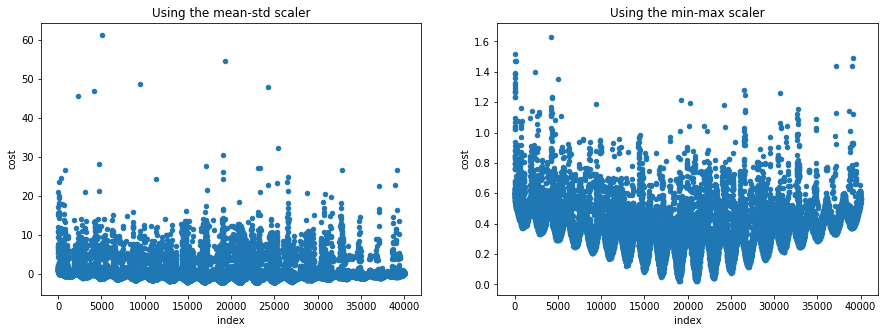

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1,ncols=2, **{'figsize':(15,5)})
res_meanstd.reset_index().plot.scatter(x='index', y='cost', ax=axes[0,], title='Using the mean-std scaler')
res_minmax.reset_index().plot.scatter(x='index', y='cost', ax=axes[1,], title='Using the min-max scaler')


Both plots show a similar pattern over all the indices (i.e. the random points). It's easier to see when the maximum cost value is limited to 5 for the mean-std scaler:

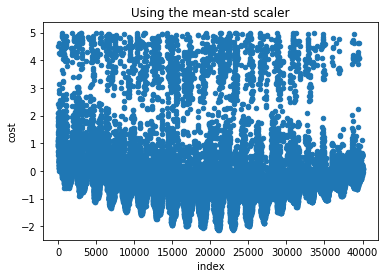

In [60]:
res_meanstd[res_meanstd['cost']<=5].reset_index().plot.scatter(x='index', y='cost', title='Using the mean-std scaler')


Rank the candidate locations by the smallest cost value:

In [61]:
def rank_candidates(df):
    dummy = df.copy()
    dummy['ranking'] = dummy['cost'].rank(ascending=True)
    return dummy
    

# example:
df_ = rank_candidates(res_meanstd)
df_ = rank_candidates(res_minmax)
df_[df_['ranking']<=10]

x             y       f_1       f_2  f_3  f_4  f_5  \
18952  392469.478006  5.820194e+06  0.006738  0.014167  0.0  0.0  0.0   
19000  392511.442968  5.820406e+06  0.006065  0.007119  0.0  0.0  0.0   
19079  392510.776106  5.820335e+06  0.006068  0.008500  0.0  0.0  0.0   
19093  392410.219297  5.820451e+06  0.008140  0.007801  0.0  0.0  0.0   
20991  392516.834451  5.820255e+06  0.005702  0.010053  0.0  0.0  0.0   
21030  392594.531609  5.820295e+06  0.005045  0.007293  0.0  0.0  0.0   
21037  392463.772103  5.820296e+06  0.006825  0.010949  0.0  0.0  0.0   
21067  392550.398027  5.820401e+06  0.005475  0.006676  0.0  0.0  0.0   
21070  392465.301136  5.820435e+06  0.006863  0.007127  0.0  0.0  0.0   
21073  392469.483414  5.820405e+06  0.006871  0.007689  0.0  0.0  0.0   

            f_6      cost  ranking  
18952  0.016324  0.023686      4.0  
19000  0.027956  0.025897      6.0  
19079  0.022798  0.023634      3.0  
19093  0.026119  0.026864      8.0  
20991  0.020824  0.023088      2.0  
21030  0.030784  0.026882      9.0  
21037  0.015602  0.021390      1.0  
21067  0.031175  0.027090     10.0  
21070  0.027162  0.026064      7.0  
21073  0.024504  0.024813      5.0

In [62]:
def plot_best_candidates(df, n: int, boroughs_loc: dict, mp=None):
    """Plots the n candidates with the lowest cost.
    
    The candidate with the minimum cost is coloured red
    while the rest are coloured black.
    
    Arguments:
    ----------       
    df: pandas.DataFrame,
        The dataframe containing the x, y coordinates, the cost
        and the ranking.
    
    n: int,
        The n best candidate locations to plot on the map.
    
    boroughs_loc: dict,
        A geojson file of the borough bounds to plot.
        
    mp: object, (optional; default=None)
        A folium map object to plot the candidates on.
    """
    df_rank = rank_candidates(df)
    
    # get the x, y coordinates of the best location
    best_x = df_rank[df_rank['ranking']==1]['x'].values[0]
    best_y = df_rank[df_rank['ranking']==1]['y'].values[0]
    
    # get the x, y coordinates of the next n-1 best locations
    x = df_rank[(df_rank['ranking']<=n).values & (df_rank['ranking']>1).values]['x'].values
    y = df_rank[(df_rank['ranking']<=n).values & (df_rank['ranking']>1).values]['y'].values

    if not mp:
        mp = folium.Map(location=BERLIN_CENTRE, zoom_start=14)

    folium.TileLayer('cartodbpositron').add_to(mp)  # add a light shadow over the map
    folium.Marker(BERLIN_CENTRE, popup=ADDRESS.split(',')[0]).add_to(mp)
    lon, lat = lonlat_to_xy(Lon=best_x, Lat=best_y, inverse=True)
    folium.Circle([lat, lon], radius=1,
                  color='red',
                  fill=True, fill_opacity=1).add_to(mp)
    lon, lat = lonlat_to_xy(Lon=x, Lat=y, inverse=True)
    for i, ln in enumerate(lon):
        folium.Circle([lat[i], ln], radius=1,
                      color='black',
                      fill=True, fill_opacity=1).add_to(mp)

    # add the borough boundaries
    folium.GeoJson(boroughs_loc, style_function=style_boroughs, name='geojson').add_to(mp)
    
    return mp


In [165]:
# create the heatmap showing all restaurants

data_to_plot = dfcp[['lat', 'lng']]
# data_to_plot = dfcp[dfcp['restaurant type']=='Other restaurants'][['lat', 'lng']]
# heatmap_colours = {0.4: 'blue', 0.65: 'lime', 1: 'red'}
# heatmap_colours = {1.0: 'blue', 0.0: 'lime', 0.0: 'red'}
heatmap_colours = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
berlin_map_all = plot_heatmap(BERLIN_CENTRE, data_to_plot, berlin_boroughs, colours=heatmap_colours)

# heatmap_colours = {0.0: 'blue', 1.0: 'lime', 0.0: 'red'}
# data_to_plot = dfcp[dfcp['restaurant type']=='Other Asian'][['lat', 'lng']]
# berlin_map_asian = plot_heatmap(BERLIN_CENTRE, data_to_plot, berlin_boroughs, berlin_map_all, colours=heatmap_colours)

# heatmap_colours = {0.0: 'blue', 0.0: 'lime', 1: 'red'}
# data_to_plot = dfcp[dfcp['restaurant type']=='Vietnamese'][['lat', 'lng']]
# berlin_map_asian = plot_heatmap(BERLIN_CENTRE, data_to_plot, berlin_boroughs, berlin_map_all, colours=heatmap_colours)

# add to it the best candidate locations
mmp = plot_best_candidates(res_meanstd, 100, berlin_boroughs, berlin_map_all)
# mmp = plot_best_candidates(res_minmax, 100, berlin_boroughs, berlin_map_all)
mmp

The figure shows the best 100 candidate locations (circles) and a heatmap with the location of any type of restaurant where the darker the colour is, the higher the restaurant concentration.

It can be clearly seen that the best ranked candidate locations satisfy all the criteria set at the beginning. Most importantly, they fall within a region where there are no restaurants and this reduces the immediate competition from foot traffic. The candidate location that gave the smallest cost is shown in red and it appears to fall within a region where there are more candidates. Comparing the individual weighted feature values will allow us to see which particular feature(s) made the difference in choosing one candidate over the other:

In [72]:
res_meanstd = rank_candidates(res_meanstd)
res_meanstd[res_meanstd['ranking']<=10].drop(labels=['x', 'y', 'cost', 'ranking'], axis=1) * params['weights']

f_1       f_2       f_3       f_4       f_5       f_6
20952 -0.187807 -0.090401 -0.150189 -0.111308 -0.224975 -1.353820
20977 -0.119742 -0.105906 -0.150189 -0.111308 -0.224975 -1.405938
21003 -0.078352 -0.036943 -0.150189 -0.111308 -0.224975 -1.513861
21044 -0.077169 -0.048355 -0.150189 -0.111308 -0.224975 -1.509819
21083 -0.107918 -0.031601 -0.150189 -0.111308 -0.224975 -1.499006
21087 -0.115783 -0.019511 -0.150189 -0.111308 -0.224975 -1.494115
22949 -0.115620 -0.112101 -0.150189 -0.111308 -0.224975 -1.404947
22984 -0.144029 -0.117324 -0.150189 -0.111308 -0.224975 -1.371350
22994 -0.140135 -0.116007 -0.150189 -0.111308 -0.224975 -1.369855
22996 -0.147233 -0.116130 -0.150189 -0.111308 -0.224975 -1.370415

In [73]:
res_meanstd[res_meanstd['ranking']<=10][['cost', 'ranking']]

cost  ranking
20952 -2.118499      6.0
20977 -2.118058      7.0
21003 -2.115628      9.0
21044 -2.121815      2.0
21083 -2.124996      1.0
21087 -2.115881      8.0
22949 -2.119140      5.0
22984 -2.119174      4.0
22994 -2.112468     10.0
22996 -2.120250      3.0

Let's get the address of the 10 best candidate location points:

In [89]:
# now the dataframe res_meanstd also contains the ranking
lo, la = lonlat_to_xy(res_meanstd[res_meanstd['ranking']<=10]['x'].values,
                      res_meanstd[res_meanstd['ranking']<=10]['y'].values,
                      inverse=True)
# to get all the addresses just use the code below (takes some time to run):
# lo, la = lonlat_to_xy(res_meanstd['x'].values,
#                       res_meanstd['y'].values,
#                       inverse=True)

addresses = list()
for i, item in enumerate(lo):
    # get the address and discard the country
    address = ','.join(reverse_address_coordinates([la[i], item]).address.split(',')[:-1])
    addresses.append(address)
    
addresses

['Rathaus Mitte, 31, Karl-Marx-Allee, Mitte, Berlin, 10178',
 'U Schillingstraße, Karl-Marx-Allee, Mitte, Berlin, 10178',
 'Haus des Reisens, 7, Alexanderstraße, Mitte, Berlin, 10178',
 'Haus des Reisens, 7, Alexanderstraße, Mitte, Berlin, 10178',
 'Haus des Reisens, 7, Alexanderstraße, Mitte, Berlin, 10178',
 'Haus des Reisens, 7, Alexanderstraße, Mitte, Berlin, 10178',
 'U Schillingstraße, Karl-Marx-Allee, Mitte, Berlin, 10178',
 'Kino International, 33, Karl-Marx-Allee, Mitte, Berlin, 10178',
 'Kino International, 33, Karl-Marx-Allee, Mitte, Berlin, 10178',
 'Kino International, 33, Karl-Marx-Allee, Mitte, Berlin, 10178']

As can be seen many of these points share the same address, due to their proximity, and some of them are not suitable locations such as 'U Schillingstraße, Karl-Marx-Allee, Mitte, Berlin, 10178' which is a metro station. At this point, the locations that do make sense can be forwarded to the stakeholder as the final recommendations. However, we can also group the points in meaningful clusters and use the addresses of the cluster centres as the recommendations for further "on ground" exploration by the stakeholder.

Let's go ahead and cluster the 100 best points then. Looking at the previous map it seems that the clusters (based on proximity) are not complex. Therefore the simple yet powerful k-means clustering technique might be a suitable choice.

In [157]:
from sklearn.cluster import KMeans

K = 10  # maximum number of clusters to test

best_locs = res_meanstd[res_meanstd['ranking']<=100][['x', 'y']].values
cluster_centers = list()
wssd = list()
for k in range(1, K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(best_locs)
    cluster_centers.append([lonlat_to_xy(cc[0], cc[1], inverse=True) for cc in kmeans.cluster_centers_])

    # Sum of squared distances of samples to their closest cluster center
    wssd.append(kmeans.inertia_)


Text(0, 0.5, 'Within-cluster sum of squared distances')

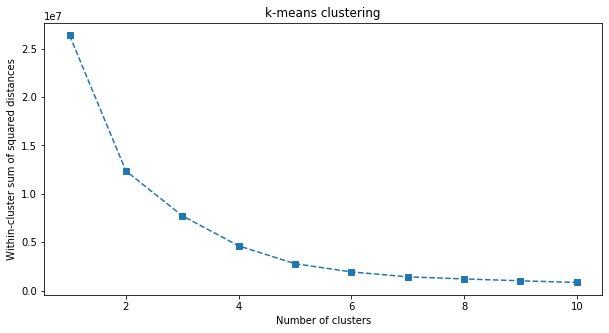

In [158]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(1, K, K), wssd, '--s')
plt.title('k-means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squared distances')

As expected the within-cluster sum of squared distances (wssd) drops as the number of clusters increases due to the formation of smaller clusters. The smaller wssd is the more closely packed are the cluster samples. It can be seen that for more than 7 clusters the reduction in wssd is small so 7 clusters is a suitable choice. A larger number can be choisen but this means increased computational costs.

Let's go ahead and plot the areas centred at the cluster centroids (radius of 300 meters) which are worth checking out. These areas represent groupings of the best candidate locations.

In [169]:
n_cluster_choice = 7
m = plot_best_candidates(res_meanstd, 100, berlin_boroughs, berlin_map_all)
for lon, lat in cluster_centers[n_cluster_choice-1]:
    folium.Circle([lat, lon], radius=300, color='green', fill=True, fill_opacity=0.25).add_to(m) 
    folium.Marker([lat, lon], popup=ADDRESS.split(',')[0]).add_to(m)
m


The addresses of the area centres:

In [170]:
all_addresses = list()
for lo,la in cluster_centers[n_cluster_choice-1]:
    # get the address and discard the country
    address = ','.join(reverse_address_coordinates([la, lo]).address.split(',')[:-1])
    all_addresses.append(address)

all_addresses

['Haus des Reisens, 7, Alexanderstraße, Mitte, Berlin, 10178',
 'Max-Planck-Oberschule (Gymnasium), 8a, Singerstraße, Mitte, Friedrichshain-Kreuzberg, Berlin, 10179',
 '19, Karl-Marx-Allee, Mitte, Berlin, 10178',
 'Fröbel-Kindergarten Schatzinsel, 7-8, Fischerinsel, Mitte, Berlin, 10179',
 '38, Saarbrücker Straße, Kollwitzkiez, Prenzlauer Berg, Pankow, Berlin, 10405',
 'Charlotte-Pfeffer-Schule, 8, Berolinastraße, Mitte, Berlin, 10178',
 'Cafe Moskau, Karl-Marx-Allee, Mitte, Berlin, 10178']

Again we can see that some of these should be discarded such as the Gymnasium and the Kindergarten. This can be done manually. And bare in mind that in this case the final recommendation is the centre of an area that contains locations that satisfy the stakeholder criteria and should be further explored on the ground. 

As a side note, choosing a different number of clusters parameter would result to a different number of final addresses.

## Results and Discussion <a name="results"></a>

The addresses recommended are obtained based on the specific weight values used (see `params['weights']`). Changing these values, based on the stakeholder requirements, would likely change the addresses that will be recommended.

There is still room for improvement, for example:
* Adding census data to determine the purchasing power of the people that live/work/go out in particular areas.
* Tourist visits per area (or per landmark)
* Foot traffic per area
* Or even creating a profile of the people that regularly visit Vietnamese restaurants and finding out through census data where these kind of people live or work. Such a profile can be constructed for example by looking at the restaurant reviews on websites such as Trip Advisor.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify suitable locations close to the city center with low number of restaurants (especially Vietnamese and other Asian) in order to guide the stakeholders in narrowing down the search for a good location for a new Vietnamese restaurant. 

Restaurant information was was obtained using the Foursquare API. Some exploratory analysis was performed using visualisations and basic data analysis. Candidate locations were then randomly generated within specific grid areas. Based on the stakeholder requirements certain features were extracted from the dataset which were used to compute a candidate location cost. This cost was used to rank the candidate locations in order to choose the most suitable ones as recommended areas. Clustering of these candidate points was also performed in order to identify general areas of interest that are worth exploring further by the stakeholder.

The addresses of the candidate locations or of the cluster centroids are found to be the best given the set of constraints defined at the beginning. For best visibility it is advisable to open the restaurant on a major road within the recommended areas. 

Further "on ground" analysis is also recommended to choose the final location to open a Vietnamese restaurant. Such analysis will likely involve the building condition, amount of rent or capital needed to buy it, renovation costs (if applicable) as well as visibility, access to foot traffic etc. There are a lot more to consider for opening a restaurant. However, if the decision is based solely on location then the work presented in this notebook can be used as a good starting point. 